In [39]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from functools import partial
import networkx as nx
# penny
import pennylane as qml
from pennylane.transforms import compile, commutation_dag
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity as fidelity_qiskit
from math import pi
import copy

In [60]:
from transpilation_util import *

In [4]:
[ds] = qml.data.load("ketg`pt")

In [77]:
random.seed(42)
seed = random.randint(0,1000)

def summary_penny(circuit):
    obj = qml.specs(circuit)()['resources']
    summary =  [obj.num_wires, obj.num_gates, obj.gate_sizes[1], obj.gate_sizes[2], obj.depth]
    df = pd.DataFrame(summary, index=['num_qubit', 'num_gate', 'num_1q_gate', 'num_2q_gate', 'depth'])
    df = df.T
    print(df)

In [82]:
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

fig, axs = qml.draw_mpl(circuit, style='pennylane')()
fig.savefig('example_circuit.png')
plt.show()

   num_qubit  num_gate  num_1q_gate  num_2q_gate  depth
0         11       903          417          486    400
None


In [24]:
# compile
transpiled_circuit = compile(circuit)
print(summary_penny(transpiled_circuit))

fig, axs = qml.draw_mpl(transpiled_circuit, style='pennylane')()
fig.savefig('example_transpiled_circuit.png')
plt.show()

   num_qubit  num_gate  num_1q_gate  num_2q_gate  depth
0         11       795          319          476    378
None


In [21]:
fidelity_penny(circuit(), transpiled_circuit())

0.9999999999998743

In [83]:
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev)
def simple_circuit():
    x = np.pi / 4
    y = np.pi / 3
    z = np.pi / 2
    qml.RX(x, wires=0)
    qml.RX(y, wires=0)
    qml.CNOT(wires=[1, 2])
    qml.RY(y, wires=1)
    qml.Hadamard(wires=2)
    qml.CRZ(z, wires=[2, 0])
    qml.RY(-y, wires=1)
    return qml.state()

qml.draw_mpl(circuit, style='pennylane')()
plt.show()

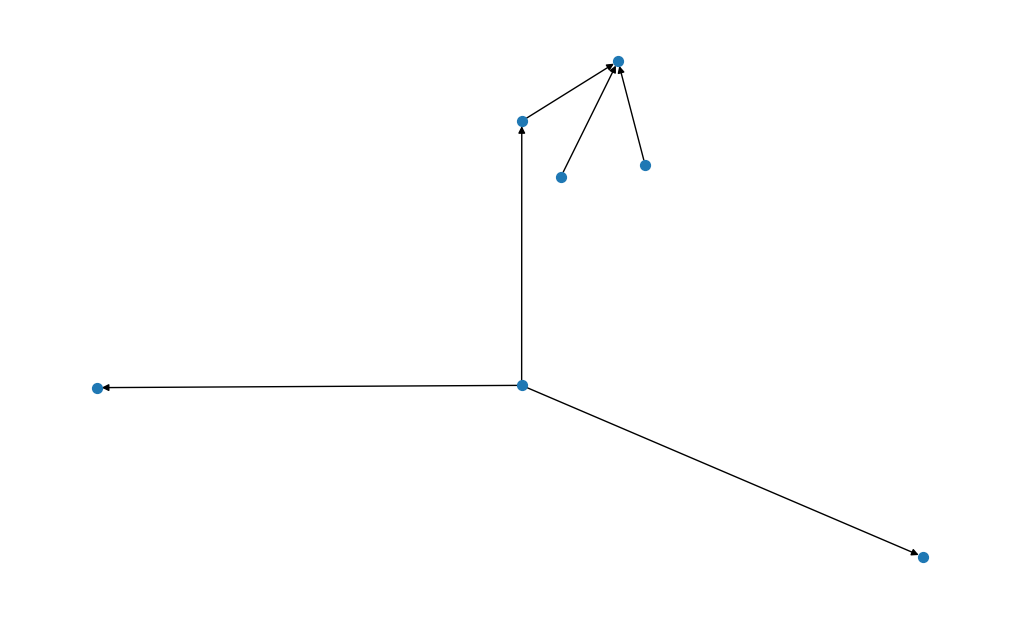

In [84]:
dag_fn = commutation_dag(simple_circuit)
dag = dag_fn()
G = dag.graph
plt.figure(figsize=(10, 6))
nx.draw(G, node_size=50, arrows=True) # pos,  
plt.show()

In [85]:
extract_info_from_qnode(simple_circuit)

[{'name': 'RX', 'wires': [0], 'params': [0.7853981633974483]},
 {'name': 'RX', 'wires': [0], 'params': [1.0471975511965976]},
 {'name': 'CNOT', 'wires': [1, 2], 'params': []},
 {'name': 'RY', 'wires': [1], 'params': [1.0471975511965976]},
 {'name': 'Hadamard', 'wires': [2], 'params': []},
 {'name': 'CRZ', 'wires': [2, 0], 'params': [1.5707963267948966]},
 {'name': 'RY', 'wires': [1], 'params': [-1.0471975511965976]}]

In [94]:
circuit_info = extract_info_from_qnode(circuit)
for dict_elem in circuit_info:
    if dict_elem['name'] in ['Hadamard', 'PauliX', 'RY', 'U1']:
        dict_elem['num_q'] = 1
    elif dict_elem['name'] in ['CNOT', 'CZ', 'U2']:
        dict_elem['num_q'] = 2
    elif dict_elem['name'] == 'QubitUnitary':
        dict_elem['num_q'] = len(dict_elem['params'][0])
    else:
        dict_elem['num_q'] = 0

In [99]:
circuit_info[10:15]

[{'name': 'CZ', 'wires': [8, 9], 'params': [], 'num_q': 2},
 {'name': 'Hadamard', 'wires': [9], 'params': [], 'num_q': 1},
 {'name': 'Hadamard', 'wires': [9], 'params': [], 'num_q': 1},
 {'name': 'CZ', 'wires': [8, 9], 'params': [], 'num_q': 2},
 {'name': 'CZ', 'wires': [8, 9], 'params': [], 'num_q': 2}]